In [1]:
from carbon import CarbonSimulatorUI, CarbonOrderUI, P, __version__, __date__
from math import sqrt, exp, log
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]
from time import time as timestamp
import os
print(f"Carbon v{__version__} ({__date__})")
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonSimulatorUI))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonOrderUI))

Carbon v2.3-BETA0 (21/Jan/2022)
CarbonSimulatorUI v2.4 (12/Jan/2023)
CarbonOrderUI v1.6 (20/Jan/2023)


# Carbon Simulation - Demo 7-2 (Sim Demo Short)

## Setup

In [10]:
OUTPATH = "/Users/skl/Desktop/sim7-2"
OUTPATH = None
if OUTPATH:
    !mkdir {OUTPATH}
    !rm {OUTPATH}/*.png

#### Define parameters

In [3]:
# spot process
pair = "ETH/USDC"
vol = 0.5
time = 1
mu = 0
steps = 100

# range
spot0      = 1500
w0         = 0.01      *vol*sqrt(time)     # gap
w1         = 2.0     *2*vol*sqrt(time)     # range
amt_usdc   = 1000
amt_eth    = 1

print(f"w1= {w1*100:.0f}% [range; {w1/vol/sqrt(time)}SD]; w0= {w0*100:.0f}% [gap; {w0/vol/sqrt(time)}SD]")

w1= 200% [range; 4.0SD]; w0= 0% [gap; 0.01SD]


In [4]:
# derived numbers
p_buy_a = spot0/(1+w0)
p_buy_b = spot0/(1+w0)/(1+w1)
p_sell_a = spot0*(1+w0)
p_sell_b = spot0*(1+w0)*(1+w1)
print(f"ETH -- BID {p_buy_b:.1f}-{p_buy_a:.1f}, SPOT {spot0:.1f}, ASK {p_sell_a:.1f}-{p_sell_b:.1f}")

ETH -- BID 497.5-1492.5, SPOT 1500.0, ASK 1507.5-4522.5


#### Calculate derived parameters

In [5]:
dt = time/steps
time_r = np.array([i*dt for i in range(steps+1)])
sqrt_dt = sqrt(dt)
mudt = mu*dt
vol_sqrt_dt = vol*sqrt_dt
half_sig2_dt = 0.5*vol*vol*dt
#print(sqrt_dt, mudt, vol_sqrt_dt)

## Simulation

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   1.4 ETH    722.5 USDC (value = 2312.7 USDC)


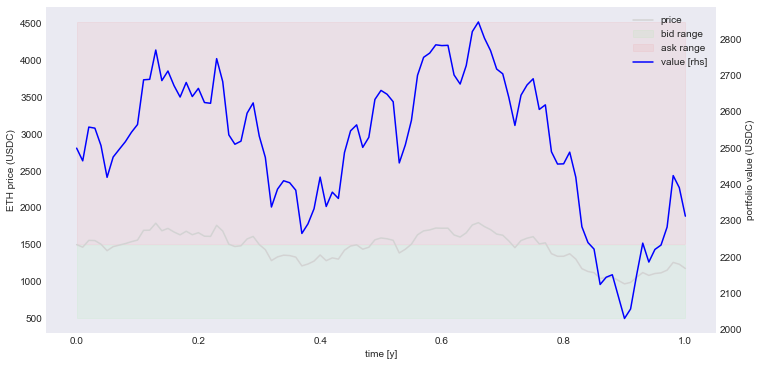

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   1.6 ETH    440.8 USDC (value = 1847.0 USDC)


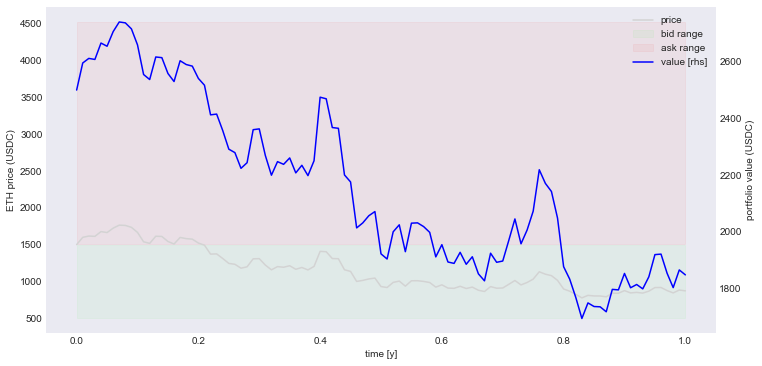

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   0.2 ETH   2968.7 USDC (value = 3466.3 USDC)


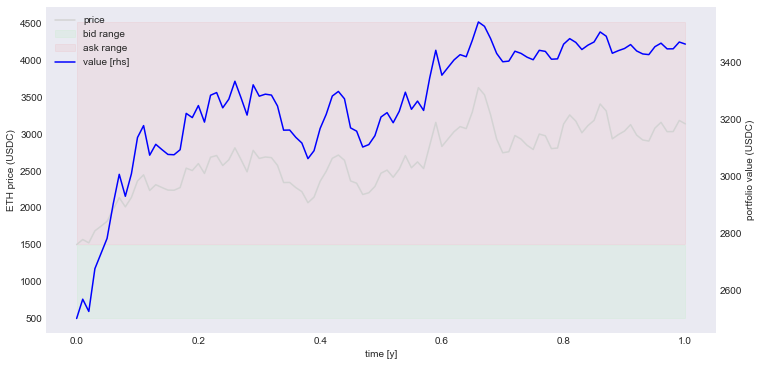

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   0.9 ETH   1244.0 USDC (value = 2425.3 USDC)


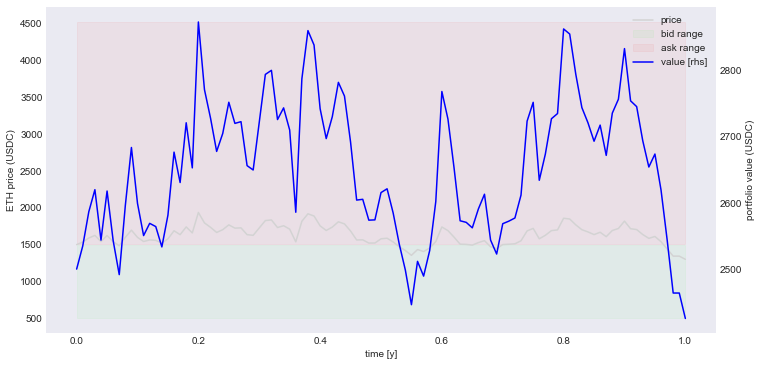

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   0.6 ETH   1785.8 USDC (value = 2882.2 USDC)


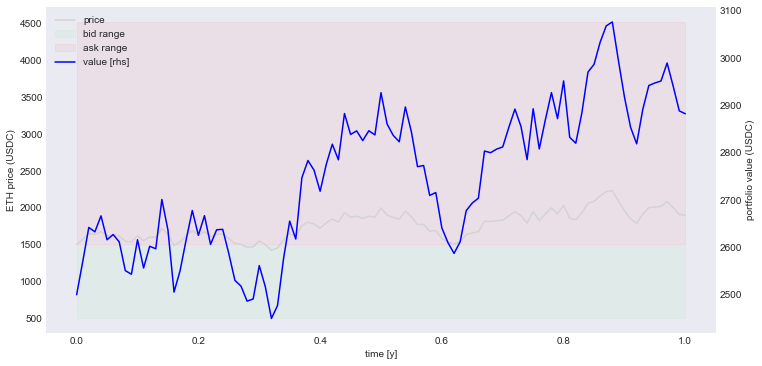

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   0.1 ETH   3030.8 USDC (value = 3446.8 USDC)


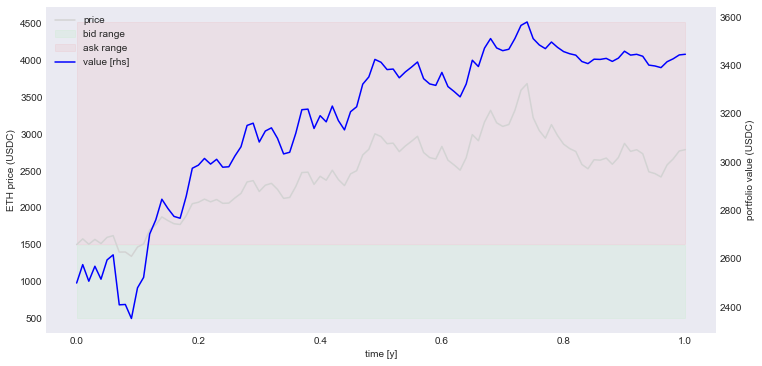

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   1.3 ETH    772.8 USDC (value = 2107.3 USDC)


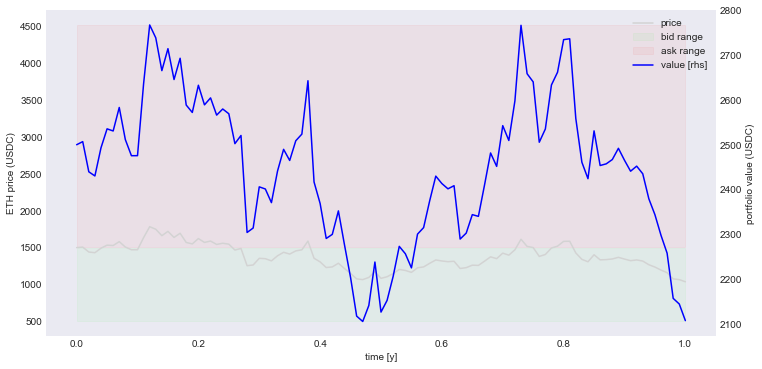

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   1.2 ETH    878.4 USDC (value = 2365.3 USDC)


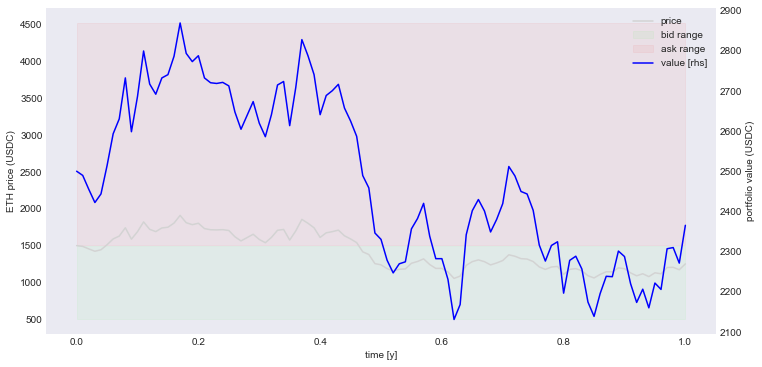

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   1.3 ETH    775.3 USDC (value = 2083.8 USDC)


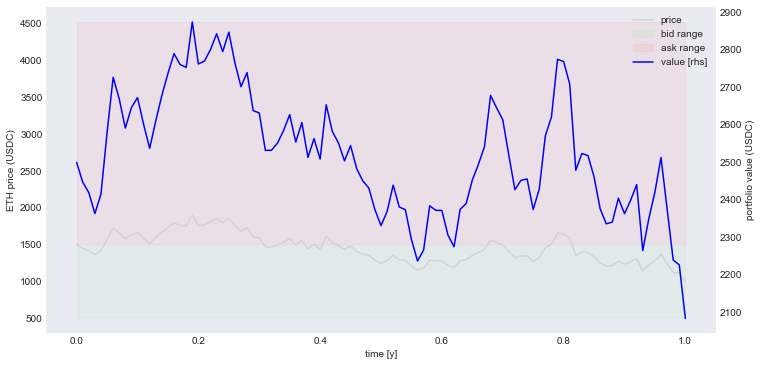

t=0.0:   1.0 ETH   1000.0 USDC (value = 2500.0 USDC)
t=1.0:   0.0 ETH   3427.5 USDC (value = 3568.4 USDC)


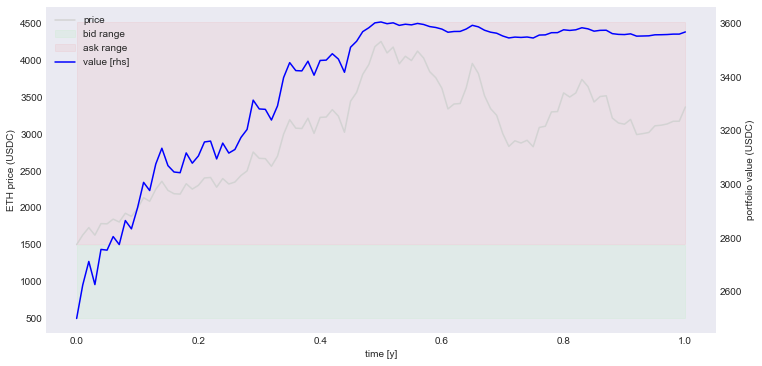

In [6]:
for ix in range(10 if not OUTPATH else 100):
    
    # #### Set up objects and generate path

    Sim = CarbonSimulatorUI(pair="ETH/USDC")
    Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
    rng = np.random.default_rng()
    increments = rng.lognormal(mean=mudt-half_sig2_dt, sigma=vol_sqrt_dt, size=steps)
    path = np.cumprod(np.insert(increments, 0, spot0))

    # #### Simulation proper

    # +
    Sim = CarbonSimulatorUI(pair="ETH/USDC", verbose=False)
    Sim.add_strategy("ETH", amt_eth, p_sell_a, p_sell_b, amt_usdc, p_buy_a, p_buy_b)
    ouis = Sim.state()["orderuis"]
    assert ouis[0].tkn == "ETH"
    assert ouis[1].tkn == "USDC"
    ethamt_r  = [ouis[0].y]
    usdcamt_r = [ouis[1].y]
    for spot in path[1:]:
        for oui in ouis.values():
            oui.tradeto(spot)
        ethamt_r  += [ouis[0].y]
        usdcamt_r += [ouis[1].y]

    amt_eth_final  = ethamt_r[-1]
    amt_usdc_final = usdcamt_r[-1]
    # -

    # #### plot values and price

    value_r = ethamt_r * path + usdcamt_r
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    plots = []
    plots += ax1.plot(time_r, path, color="lightgrey", label="price")
    plots += [ax1.fill_between(time_r, p_buy_a, p_buy_b, color="lightgreen", alpha=0.1, label="bid range")]
    plots += [ax1.fill_between(time_r, p_sell_a, p_sell_b, color="lightcoral", alpha=0.1, label="ask range")]
    plots += ax2.plot(time_r, value_r, color = "blue", label="value [rhs]")
    ax2.set_ylabel("portfolio value (USDC)")
    ax1.set_ylabel("ETH price (USDC)")
    ax1.set_xlabel("time [y]")
    labels = [p.get_label() for p in plots]
    plt.legend(plots, labels)
    print(f"t={   0:3.1f}: {ethamt_r[ 0]:5.1f} ETH {usdcamt_r[ 0]:8.1f} USDC (value = {value_r[ 0]:6.1f} USDC)")
    print(f"t={time:3.1f}: {ethamt_r[-1]:5.1f} ETH {usdcamt_r[-1]:8.1f} USDC (value = {value_r[-1]:6.1f} USDC)")
    
    # #### Show and save
    ts = f"{timestamp()*10:0.0f}"[-6:]
    if OUTPATH:
        plt.savefig(os.path.join(OUTPATH, f"sim-{ts}.png"))
    plt.show()

In [7]:
if OUTPATH:
    !ls {OUTPATH}/*.png

In [8]:
# if OUTPATH:
#     filelist = os.listdir(OUTPATH)
#     filelist = [fn for fn in filelist if fn[-4:]==".png"]
#     markdown = "".join(f"""
#     ![]({OUTPATH}/{fn})
#     """ for fn in filelist)
#     fsave(markdown, "_sim-charts.md", OUTPATH)
#     !pandoc {OUTPATH}/_sim-charts.md -o {OUTPATH}/_sim-charts.docx

In [9]:
if OUTPATH:
    from fls import fsave
    filelist = os.listdir(OUTPATH)
    filelist = [fn for fn in filelist if fn[-4:]==".png"]
    markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in filelist)
    fsave(markdown, "_sim-charts.md", OUTPATH)
    !pandoc {OUTPATH}/_sim-charts.md -o {OUTPATH}/_sim-charts.docx